In [1]:
# HIDE
import pandas as pd
import numpy as np
np.random.seed(7)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True, context="talk")
from IPython import display
%matplotlib inline

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import keras as ke
import keras.backend as K
from keras.layers import Input, Dense, Dropout
from keras.models import Model

print(f"sklearn: {sk.__version__}")
print(f"pandas: {pd.__version__}")
print(f"kerads: {ke.__version__}")

Using TensorFlow backend.


sklearn: 0.19.1
pandas: 0.22.0
kerads: 2.1.5


# Towards fairness in machine learning with adversarial networks 

## Introduction

From credit ratings to housing allocation, machine learning models are increasingly used to automate 'everyday' decision making processes. With the growing impact on society, more and more concerns are being voiced about the loss of transparency, accountability and fairness of the algorithms making the decisions. We as data scientists need to step-up our game and look for ways to mitigate emergent discrimination in our models. We need to make sure that our predictions do not disproportionately hurt people with certain sensitive characteristics (e.g., gender, ethnicity).

Luckily, [last year's NIPS conference](https://blog.godatadriven.com/gdd-nips-2017) showed that the field is actively investigating how to bring fairness to predictive models. Some approaches focus on interpretability and transparency by allowing deeper interrogation of complex, black box models. Other approaches, make trained models more robust and fair in their predictions by taking the route of constraining and changing the optimization objective.

This blog post looks at the latter approach and shows how adversarial networks can bring fairness to our predictive models. We will train a classifier for making income level predictions, analyse the fairness of its predictions and then show how adversarial training can be used to it fair.

This approach is based on the 2017 NIPS paper ["Learning to Pivot with Adversarial Networks"](https://papers.nips.cc/paper/6699-learning-to-pivot-with-adversarial-networks) by Louppe et al. Most of the code in post itself will be omitted, however you can find the Jupyter notebook containing all the code [here](https://github.com/equialgo/fairness-in-ml/blob/master/fairness-in-ml.ipynb).

## Making income predictions

Let's start by training a basic classifier that can predict whether or not a person's income is larger than 50K dollar a year. Too make these income level predictions we turn to the [adult UCI](https://archive.ics.uci.edu/ml/datasets/Adult) dataset, which is also referred to as "Census Income" dataset. It is not hard to imagine that financial institutions train models on similar data sets and use them to decide whether or not someone is eligible for a loan, or to set the height of an insurance premium.

Before training a model, we first parse the data into three datasets: features, targets and sensitive attributes. The set of features $X$ contains the input attributes that the model uses for making the predictions, with attributes like age, education level and occupation. The targets $y$ contain the binary class labels that the model needs to predict.  These labels are $y\in\left\{income>50K, income\leq 50K\right\}$. Finally, the set of sensitive attributes $Z$ contains the attributes for which we want the prediction to fair. These are $z_{race}\in\left\{black, white\right\}$ and $z_{sex}\in\left\{male, female\right\}$. 

It is important to note that datasets are non-overlapping, so the sensitive attributes race and sex are **not** part of the features used for training the model.


In [2]:
# HIDE
def load_ICU_data(path):
    column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 
                    'martial_status', 'occupation', 'relationship', 'race', 'sex', 
                    'capital_gain', 'capital_loss', 'hours_per_week', 'country', 'target']
    input_data = (pd.read_csv(path, names=column_names, 
                              na_values="?", sep=r'\s*,\s*', engine='python')
                  .loc[lambda df: df['race'].isin(['White', 'Black'])])

    # sensitive attributes; we identify 'race' and 'sex' as sensitive attributes
    sensitive_attribs = ['race', 'sex']
    Z = (input_data.loc[:, sensitive_attribs]
         .assign(race=lambda df: (df['race'] == 'White').astype(int),
                 sex=lambda df: (df['sex'] == 'Male').astype(int)))

    # targets; 1 when someone makes over 50k , otherwise 0
    y = (input_data['target'] == '>50K').astype(int)

    # features; note that the 'target' and sentive attribute columns are dropped
    X = (input_data
         .drop(columns=['target', 'race', 'sex'])
         .fillna('Unknown')
         .pipe(pd.get_dummies, drop_first=True))
    
    print(f"features X: {X.shape[0]} samples, {X.shape[1]} attributes")
    print(f"targets y: {y.shape} samples")
    print(f"sensitives Z: {Z.shape[0]} samples, {Z.shape[1]} attributes")
    return X, y, Z

In [3]:
# load ICU data set
X, y, Z = load_ICU_data('data/adult.data')

features X: 30940 samples, 94 attributes
targets y: (30940,) samples
sensitives Z: 30940 samples, 2 attributes


Our dataset contains the information of just over 30K people. Next, we split the data into train and test sets, where the split is 50/50, and scale the features $X$ using standard scaling.

In [4]:
# split into train/test set
X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(X, y, Z, test_size=0.5, 
                                                                     stratify=y, random_state=7)

# standardize the data
scaler = StandardScaler().fit(X_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)
X_train = X_train.pipe(scale_df, scaler) 
X_test = X_test.pipe(scale_df, scaler) 

Now, let's train our basic income level predictor. We use Keras to fit a simple three-layer network with ReLU activations and dropout on the training data. The output of the network is a single node with sigmoid activation, so it predicts "the probability that this person's income is larger than 50K".

In [5]:
def nn_classifier(n_features):
    inputs = Input(shape=(n_features,))
    dense1 = Dense(32, activation='relu')(inputs)
    dropout1 = Dropout(0.2)(dense1)
    dense2 = Dense(32, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(dense2)
    dense3 = Dense(32, activation="relu")(dropout2)
    dropout3 = Dropout(0.2)(dense3)
    outputs = Dense(1, activation='sigmoid')(dropout3)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

clf = nn_classifier(n_features=X_train.shape[1])
history = clf.fit(X_train, y_train, epochs=20, verbose=0)

Finally, we use this classifier to make income level predictions on the test data. We determine the model performance by computing the [Area Under the Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) and the accuracy score using test set predictions.

In [6]:
y_pred = pd.Series(clf.predict(X_test).ravel(), index=y_test.index)
print(f"ROC AUC: {roc_auc_score(y_test, y_pred):.2f}")
print(f"Accuracy: {100*accuracy_score(y_test, (y_pred>0.5)):.1f}%")

ROC AUC: 0.91
Accuracy: 85.0%


With a ROC AUC larger than 0.9 and a prediction accuracy of 85% we can say that our basic classifier performs pretty well! However, if it is also fair in its predictions, that remains to be seen.

## Qualitative model fairness

We start the investigation into the fairness of our classifier by analysing the predictions it made on the test set. The plots in the figure below show the distributions of the predicted $P(income>50K)$ given the sensitive attributes.

In [7]:
# HIDE
def plot_distributions(y, Z, iteration=None, val_metrics=None, p_rules=None):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)   
    legend={'race': ['black','white'],
            'sex': ['female','male']}
    for idx, attr in enumerate(Z.columns):
        for attr_val in [0, 1]:
            ax = sns.distplot(y[Z[attr] == attr_val], hist=False, 
                              kde_kws={'shade': True,},
                              label='{}'.format(legend[attr][attr_val]), 
                              ax=axes[idx])
        ax.set_xlim(0,1)
        ax.set_ylim(0,7)
        ax.set_yticks([])
        ax.set_title("sensitive attibute: {}".format(attr))
        if idx == 0:
            ax.set_ylabel('prediction distribution')
        ax.set_xlabel(r'$P({{income>50K}}|z_{{{}}})$'.format(attr))
    if iteration:
        fig.text(1.0, 0.9, f"Training iteration #{iteration}", fontsize='16')
    if val_metrics is not None:
        fig.text(1.0, 0.65, '\n'.join(["Prediction performance:",
                                       f"- ROC AUC: {val_metrics['ROC AUC']:.2f}",
                                       f"- Accuracy: {val_metrics['Accuracy']:.1f}"]),
                 fontsize='16')
    if p_rules is not None:
        fig.text(1.0, 0.4, '\n'.join(["Satisfied p%-rules:"] +
                                     [f"- {attr}: {p_rules[attr]:.0f}%-rule" 
                                      for attr in p_rules.keys()]), 
                 fontsize='16')
    fig.tight_layout()
    return fig

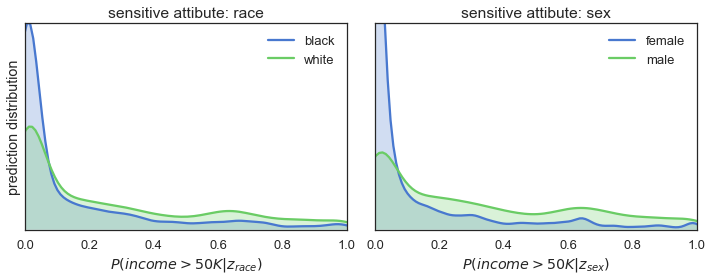

In [8]:
fig = plot_distributions(y_pred, Z_test)

The figure shows for both race (=left plot) and sex (=right plot) the blue prediction distributions have a large peak at the low end of the probability range. This means that when a person is $black$ and/or $female$ there is a much higher probability of the classifier predicting an income below 50K compared to when someone is $white$ and/or $male$.

So, the results of the qualitative analysis are quite clear: the predictions are definitely not fair when considered in the context of race and sex. When it comes to assigning the high-income levels, our model favours the usual suspects: white males.

## Quantitative model fairness

In order to get a 'quantitative' measure of how fair our classifier is, we take inspiration from the U.S. Equal Employment Opportunity Commission (EEOC). They use the so-called [80% rule](https://en.wikipedia.org/wiki/Disparate_impact#The_80%_rule) to quantify the disparate impact on a group of people of a protected characteristic. Zafar et al. show in their paper ["Fairness Constraints: Mechanisms for Fair Classification"](https://arxiv.org/pdf/1507.05259.pdf) how a more generic version of this rule, called the p%-rule, can be used to quantify fairness of a classifier. This rule is defined as follows:

> A classifier that makes a binary class prediction $\hat{y} \in \left\{0,1 \right\}$ given a binary sensitive attribute $z\in \left\{0,1 \right\}$ satisfies the p%-rule
if the following inequality holds:
>
>$$\min\left(\frac{P(\hat{y}=1|z=1)}{P(\hat{y}=1|z=0)}, \frac{P(\hat{y}=1|z=0)}{P(\hat{y}=1|z=1)}\right)\geq\frac{p}{100}$$

The rule states that the ratio between the probability of a positive outcome given the sensitive attribute being true and the same probability given the sensitive attribute being false is no less than p:100. So, when a classifier is completely fair it will satisfy a 100%-rule. In contrast, when it is completely unfair it satisfies a %0-rule. 

In determining the fairness our or classifier we will follow the EEOC and say that a model is fair when it satisfies at least an 80%-rule. So, let's compute the p%-rules for the classifier and put a number on its fairness. Note that we will threshold our classifier at 0.5 to make its prediction it binary.

In [9]:
# HIDE
def p_rule(y_pred, z_values, threshold=0.5):
    y_z_1 = y_pred[z_values == 1] > threshold if threshold else y_pred[z_values == 1]
    y_z_0 = y_pred[z_values == 0] > threshold if threshold else y_pred[z_values == 0]
    odds = y_z_1.mean() / y_z_0.mean()
    return np.min([odds, 1/odds]) * 100

In [10]:
print("The classifier satisfies the following %p-rules:")
print(f"\tgiven attribute race; {p_rule(y_pred, Z_test['race']):.0f}%-rule")
print(f"\tgiven attribute sex;  {p_rule(y_pred, Z_test['sex']):.0f}%-rule")

The classifier satisfies the following %p-rules:
	given attribute race; 45%-rule
	given attribute sex;  33%-rule


We find that for both sensitive attributes the classifier satisfies a p%-rule that is significantly lower than 80%. This supports our earlier conclusion that the trained classifier is unfair in making its predictions. 

## Fighting the bias

It is important to stress that training a fair model is not straightforward. One might be tempted to think that simply removing sensitive information from the training data is enough. Our classifier did not have access to the race and sex attributes and still we ended up with a model that is biased against women and black people. This begs the question: what caused our classifier to behave this way? 

The observed behaviour is most likely caused by biases in the training data. To understand how this works, consider the following two examples of image classification errors:

<center><br><img src="images/missclassified_images.png" alt="GAN Images" width="300"/><br></center>

The classifier that made these errors was trained on data in which some ethnic and racial minorities are overrepresented by small number of classes. For example, black people are often shown playing basketball and Asian people playing ping-pong. The model picks up on these biases and uses them for making predictions. However, once unleashed into the wild it will encounter images in which these minorities are doing things other than playing basketball or ping-pong. Still relying on its learned biases, the model can misclassify these images in quite painful ways.

Now, the UCI dataset, used for training our classifier, has similar kinds of biases in the data. The dataset is based on census data from 1994, a time in which income inequality was just as much of an issue as it is nowadays. Not surprisingly, most of the high earners in the data are white males, while women and black people are more often part of the low-income group. Our predictive model can indirectly learn these biases, for example, through characteristics like education level and zip-code of residence. As a result, we end-up with the unfair predictions observed in previous section, even after having removed the race and sex attributes.

How can we go about fixing this issue? In general, there are two approaches we can take. We can somehow try to de-bias the dataset, for example by adding additional data that comes from a more representative sample. Alternatively, we can constrain the model so that it is forced into making fairer predictions. In the next section, we will show how adversarial networks can help in taking the second approach.

## Adversarial networks FTW

In 2014, Goodfellow et al. published their seminal [paper](https://arxiv.org/abs/1406.2661) on Generative Adversarial Networks (GANs). They introduce GANs as a system of two neural networks, a generative model and an adversarial classifier, which are competing with each other in a zero-sum game. In the game, the generative model focusses on producing samples that are indistinguishable from real data, while the adversarial classifier tries to identify if samples came from the generative model or from the real data. Both networks are trained simultaneously such that the first improves at producing realistic samples, while the second becomes better at spotting the fakes from the real. The figure below shows some examples of images that were generated by a GAN:

<center><br><img src="images/gan_examples.png" alt="GAN Images" width="500"/><br></center>

Our procedure for training a fair income classifier takes inspiration from GANs: it leverages adversarial networks to enforce the so-called [pivotal property](https://en.wikipedia.org/wiki/Pivotal_quantity) on the predictive model. This statistical property assures that the outcome distribution of the model no longer depends on so-called nuisance parameters. These parameters are not of immediate interest, but must be accounted for in a statistical analysis. By taking the sensitive attributes as our nuisance parameters we can enforce predictions that are independent of, in our case, race and sex. This is exactly what we need for making fair predictions!

## Adversarial training procedure

The starting point for adversarial training our classifier is the extension of the original network architecture with an adversarial component. The figure below shows what this extended architecture looks like:

<center><br><img src="images/architecture.png" alt="Architecture" width="750"/><br></center>

At first glance, this system of two neural networks looks very similar to the one used for training GANs. However, there are some key differences. First, the generative model has been replaced by a predictive model. So, instead of generating synthetic data it now generates actual predictions $\hat{y}$ based on the input $X$. Second, the task of the adversarial is no longer to distinguish real from generated data. Instead, it predicts the sensitive attribute values $\hat{z}\in\hat{Z}$ from the predicted $\hat{y}$ of the classifier. Finally, the objectives that both nets try to optimize are based on the prediction losses of the target and sensitive attributes, these are denoted by $Loss_{y}(\theta_{clf})$ and $Loss_{Z}(\theta_{clf},\theta_{adv})$ in the figure.

Let’s consider the nature of the zero-sum game the classifier and adversarial are engaged in. For the classifier the objective of twofold: make the best possible income level predictions whilst ensuring that race or sex cannot be derived from them. This is captured by the following objective function:

$$\min_{\theta_{clf}}\left[Loss_{y}(\theta_{clf})-\lambda Loss_{Z}(\theta_{clf},\theta_{adv})\right].$$

So, it learns to minimize its own prediction losses while maximizing that of the adversarial (due to $\lambda$ being positive and minimizing a negated loss is the same as maximizing it). Note that increasing the size of $\lambda$ steers the classifier towards fairer predictions while sacrificing prediction accuracy. The objective during the game is simpler For the adversarial: predict race and sex based on the income level predictions of the classifier. This is captured in the following objective function:

$$\min_{\theta_{adv}}\left[Loss_{Z}(\theta_{clf},\theta_{adv})\right].$$

The adversarial does not care about the prediction accuracy of the classifier. It is only concerned with minimizing its own prediction losses.

Now that our classifier is upgraded with an adversarial component, we turn to the adversarial training procedure. In short, we can summarize this procedure in the following 3 steps:

1. Pre-train the classifier on the full data set.
2. Pre-train the adversarial on the predictions of the pre-trained classifier.
3. During $T$ iterations simultaneously train the adversarial and classifier networks:
   - first train the adversarial for a single epoch while keeping the classifier fixed
   - then train the classifier on a single sampled mini batch while keeping the adversarial fixed.

The actual adversarial training starts only after the first two pre-training steps. It is then that the training procedure mimics the zero-sum game during which our classifier will (hopefully) learn how make predictions that are both accurate and fair.

## Fair income predictions

Finally, we are ready to adverserial train a fair classifier. We kick-off by initializing our newly upgraded classifier and pre-train both the classifier and adverserial networks:

In [11]:
n_features = X_train.shape[1]
n_sensitive = Z_train.shape[1]
lambdas=[130., 30.]

In [12]:
clf_inputs = Input(shape=(n_features,))
adv_inputs = Input(shape=(1,))

In [13]:
# HIDE

class FairClassifier(object):
    
    def __init__(self, n_features, n_sensitive, lambdas):
        self.lambdas = lambdas
        
        clf_inputs = Input(shape=(n_features,))
        adv_inputs = Input(shape=(1,))
        
        clf_net = self._create_clf_net(clf_inputs)
        adv_net = self._create_adv_net(adv_inputs, n_sensitive)
        self._trainable_clf_net = self._make_trainable(clf_net)
        self._trainable_adv_net = self._make_trainable(adv_net)
        self._clf = self._compile_clf(clf_net)
        self._clf_w_adv = self._compile_clf_w_adv(clf_inputs, clf_net, adv_net)
        self._adv = self._compile_adv(clf_inputs, clf_net, adv_net, n_sensitive)
        self._val_metrics = None
        self._fairness_metrics = None
        
        self.predict = self._clf.predict
        
    def _make_trainable(self, net):
        def make_trainable(flag):
            net.trainable = flag
            for layer in net.layers:
                layer.trainable = flag
        return make_trainable
        
    def _create_clf_net(self, inputs):
        dense1 = Dense(32, activation='relu')(inputs)
        dropout1 = Dropout(0.2)(dense1)
        dense2 = Dense(32, activation='relu')(dropout1)
        dropout2 = Dropout(0.2)(dense2)
        dense3 = Dense(32, activation='relu')(dropout2)
        dropout3 = Dropout(0.2)(dense3)
        outputs = Dense(1, activation='sigmoid', name='y')(dropout3)
        return Model(inputs=[inputs], outputs=[outputs])
        
    def _create_adv_net(self, inputs, n_sensitive):
        dense1 = Dense(32, activation='relu')(inputs)
        dense2 = Dense(32, activation='relu')(dense1)
        dense3 = Dense(32, activation='relu')(dense2)
        outputs = [Dense(1, activation='sigmoid')(dense3) for _ in range(n_sensitive)]
        return Model(inputs=[inputs], outputs=outputs)

    def _compile_clf(self, clf_net):
        clf = clf_net
        self._trainable_clf_net(True)
        clf.compile(loss='binary_crossentropy', optimizer='adam')
        return clf
        
    def _compile_clf_w_adv(self, inputs, clf_net, adv_net):
        clf_w_adv = Model(inputs=[inputs], outputs=[clf_net(inputs)]+adv_net(clf_net(inputs)))
        self._trainable_clf_net(True)
        self._trainable_adv_net(False)
        loss_weights = [1.]+[-lambda_param for lambda_param in self.lambdas]
        clf_w_adv.compile(loss=['binary_crossentropy']*(len(loss_weights)), 
                          loss_weights=loss_weights,
                          optimizer='adam')
        return clf_w_adv

    def _compile_adv(self, inputs, clf_net, adv_net, n_sensitive):
        adv = Model(inputs=[inputs], outputs=adv_net(clf_net(inputs)))
        self._trainable_clf_net(False)
        self._trainable_adv_net(True)
        adv.compile(loss=['binary_crossentropy']*n_sensitive, optimizer='adam')
        return adv

    def _compute_class_weights(self, data_set):
        class_values = [0, 1]
        class_weights = []
        if len(data_set.shape) == 1:
            balanced_weights = compute_class_weight('balanced', class_values, data_set)
            class_weights.append(dict(zip(class_values, balanced_weights)))
        else:
            n_attr =  data_set.shape[1]
            for attr_idx in range(n_attr):
                balanced_weights = compute_class_weight('balanced', class_values,
                                                        np.array(data_set)[:,attr_idx])
                class_weights.append(dict(zip(class_values, balanced_weights)))
        return class_weights
    
    def _compute_target_class_weights(self, y):
        class_values  = [0,1]
        balanced_weights =  compute_class_weight('balanced', class_values, y)
        class_weights = {'y': dict(zip(class_values, balanced_weights))}
        return class_weights
        
    def pretrain(self, x, y, z, epochs=10, verbose=0):
        self._trainable_clf_net(True)
        self._clf.fit(x, y, epochs=epochs, verbose=verbose)
        self._trainable_clf_net(False)
        self._trainable_adv_net(True)
        class_weight_adv = self._compute_class_weights(z)
        self._adv.fit(x, np.hsplit(z, z.shape[1]), class_weight=class_weight_adv, 
                      epochs=epochs, verbose=verbose)
        
    def fit(self, x, y, z, validation_data=None, T_iter=250, batch_size=128,
            weight_sensitive_classes=True, save_figs=False):
        n_sensitive = z.shape[1]
        if validation_data is not None:
            x_val, y_val, z_val = validation_data

        class_weight_adv = self._compute_class_weights(z)
        class_weight_clf_w_adv = [{0:1., 1:1.}]+class_weight_adv
        self._val_metrics = pd.DataFrame()
        self._fairness_metrics = pd.DataFrame()  
        for idx in range(T_iter):
            if validation_data is not None:
                y_pred = pd.Series(clf.predict(x_val).ravel(), index=y_val.index)
                self._val_metrics.loc[idx, 'ROC AUC'] = roc_auc_score(y_val, y_pred)
                self._val_metrics.loc[idx, 'Accuracy'] = (accuracy_score(y_val, (y_pred>0.5))*100)
                for sensitive_attr in z_val.columns:
                    self._fairness_metrics.loc[idx, sensitive_attr] = p_rule(y_pred,
                                                                             z_val[sensitive_attr])
                display.clear_output(wait=True)
                plot_distributions(y_pred, z_val, idx+1, self._val_metrics.loc[idx],
                                   self._fairness_metrics.loc[idx])
                if save_figs:
                    plt.savefig(f'output/{idx+1:08d}.png', bbox_inches='tight')
                plt.show(plt.gcf())
            
            # train adverserial
            self._trainable_clf_net(False)
            self._trainable_adv_net(True)
            self._adv.fit(x, np.hsplit(z, z.shape[1]), batch_size=batch_size, class_weight=class_weight_adv,
                          epochs=1, verbose=0)
            
            # train classifier
            self._trainable_clf_net(True)
            self._trainable_adv_net(False)
            indices = np.random.permutation(len(x))[:batch_size]
            self._clf_w_adv.train_on_batch(x.values[indices], 
                                           [y.values[indices]]+np.hsplit(z.values[indices], n_sensitive),
                                           class_weight=class_weight_clf_w_adv)

In [14]:
clf = FairClassifier(n_features=X_train.shape[1], n_sensitive=Z_train.shape[1],
                     lambdas=[130., 30.])
clf.pretrain(X_train, y_train, Z_train, verbose=0, epochs=5)

The supplied $\lambda$ values, that tune fairness versus accuracy, are set to $\lambda_{race}=130$ and $\lambda_{sex}=30$. We heuristically found that these result in a balanced increase of the p%-rule values during training. Apparently, it is slightly harder to enforce fairness for the racial attributes than for sex.

Now that both networks have been pre-trained, the adversarial training can start. We will simultaneously train both networks for 165 iterations while tracking the performance of the classifier on the test data:

In [15]:
# HIDE
!rm output/*.png

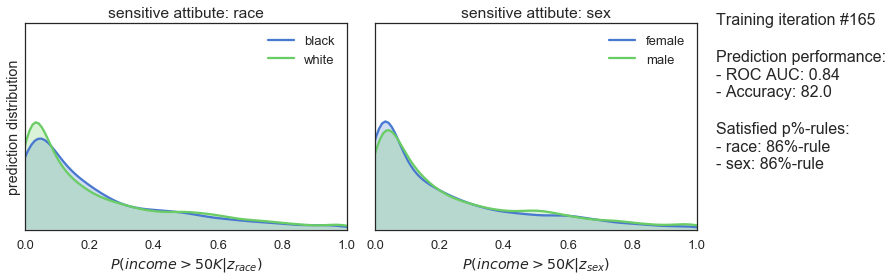

In [16]:
clf.fit(X_train, y_train, Z_train, 
        validation_data=(X_test, y_test, Z_test),
        T_iter=165, save_figs=True)

In [17]:
# HIDE
!convert -loop 0 -delay 0 output/*.png -delay 500 output/00000165.png images/training.gif

<center><br><img src="images/training.gif" alt="Architecture" width="1000"/><br></center>

The plots above show how the prediction distributions, the satisfied p%-rules and the prediction performance of our classifier evolve during adversarial training. At iteration #1, when training is just starting out, the predictions are very much the same as observed for the previously trained classifier: both high in bias and in prediction performance. As the training progresses, we see that the predictions are gradually become more and more fair while prediction performance is slightly declining. Finally, after 165 iterations of adversarial training, we see that the classifier satisfies the 80%-rule for both sensitive attributes while achieving a ROC AUC 0.85 and an accuracy of 82%. 

So, it seems that the adversarial training procedure works quite well. After sacrificing only 7% of prediction performance, we end up with a classifier that makes fair predictions when it comes to race and sex. A pretty decent result!


## Conclusions

In this blog post we have shown that bringing fairness to predictive models is not as straight forward as just removing some sensitive attributes from the training data. It requires clever techniques, like adverserial training, to correct for the often deeply biased training data and force our models into making fair predictions. And yes, making fair prediction comes at a price: it will reduce the prediction performance of your model (hopefully, only by a little as in our example). However, we believe that in many cases this will only a small price to pay for leaving behind the biased world of yesterday and predicting our way into a fairer tomorrow!